# [Optional] Module 4: Advanced Example using HRNN-Metadata Recipe with MovieLens Data

`
Rev Date           By       Description
PA1 2020-02-16     akirmak  Modified and extended version of one of the Amazon Personalize samples at github AWS-samples
`

The notebook demonstrates using Item metadata with HRNN-Metadata recipe. 

If you are interested in doing another exercise, this time using the HRNN-Metadata Recipe, this module is a modified version of an advanced example from Amazon Personalize samples at github AWS-samples: https://github.com/aws-samples/amazon-personalize-samples/blob/master/advanced_examples/personalize_temporal_holdout.ipynb

It also demonstrates holding-out 1% of "future" data for every user and using item meta-data. Then, an inference endpoint to bring recommendation and evaluate externally on the held-out data is also demonstrated.

Note on Costs & Duration of the Lab Module: The Movielens dataset file size used is around 600+MB, and has approximately 20M lines. The module takes longer to train than the Last.FM dataset.

In [1]:
import tempfile, subprocess, urllib.request, zipfile
import pandas as pd, numpy as np

In [2]:
import io
import scipy.sparse as ss
import json
import time
import os

In [3]:
import sagemaker.amazon.common as smac

In [4]:
import boto3

# Download and process a dataset

In [5]:
with tempfile.TemporaryDirectory() as tmpdir:
    urllib.request.urlretrieve(
        'http://files.grouplens.org/datasets/movielens/ml-20m.zip',
        tmpdir + '/ml-20m.zip')
    zipfile.ZipFile(tmpdir + '/ml-20m.zip').extractall(tmpdir)
    df = pd.read_csv(tmpdir + '/ml-20m/ratings.csv')
    movies = pd.read_csv(tmpdir + '/ml-20m/movies.csv', index_col='movieId')
    vocab_size = df.movieId.max() + 1

In [7]:
tmpdir

'/tmp/tmpw_uj9s_c'

In [8]:
vocab_size

131263

In [9]:
test_time_ratio = 0.01


## hold out the last bit of data in time

In [10]:
dfo = df.copy()
df = df[df.timestamp < df.timestamp.max() * (1-test_time_ratio) + df.timestamp.min() * test_time_ratio]

## convert into Personalize format

In [11]:
df.columns = ['USER_ID','ITEM_ID','EVENT_VALUE','TIMESTAMP']
df['EVENT_TYPE']='RATING'

In [12]:
df.head()

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,1,2,3.5,1112486027,RATING
1,1,29,3.5,1112484676,RATING
2,1,32,3.5,1112484819,RATING
3,1,47,3.5,1112484727,RATING
4,1,50,3.5,1112484580,RATING


In [11]:
#for demo we may want to upload a small dataset
#df=df.loc[:10000]

Write the DF to file. the file size is around 600+MB, and has approximately 20M lines. So this may take a few minutes. 

In [13]:
df.to_csv('movielens_interactions.csv',index=False)

## process item metadata into Personalize formats

In [14]:
movies = movies.reset_index()

del movies['title']

movies.columns=['ITEM_ID','GENRE']

In [15]:
movies.head()

,ITEM_ID,GENRE
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy


In [16]:
movies.to_csv('movielens_item_metadata.csv',index=False)

# upload data to s3

 Note: add your initials below. 

In [17]:
os.environ['AWS_DEFAULT_REGION']="us-east-1"
#suffix = str(np.random.uniform())[4:9]

#bucket = "ai-personalizepoc"+suffix     # replace with the name of your S3 bucket
# Override with your bucket or, comment out the line below to use the random bucket name above

bucket = "hba-ai-personalizepoc"
!aws s3 mb s3://{bucket}

make_bucket: hba-ai-personalizepoc


In [18]:
personalize = boto3.client(service_name='personalize', endpoint_url='https://personalize.us-east-1.amazonaws.com')
personalize_runtime = boto3.client(service_name='personalize-runtime', endpoint_url='https://personalize-runtime.us-east-1.amazonaws.com')

In [19]:
interactions_filename = 'movielens_interactions.csv'
boto3.Session().resource('s3').Bucket(bucket).Object(interactions_filename).upload_file(interactions_filename)

In [20]:
item_metadata_file = 'movielens_item_metadata.csv'
boto3.Session().resource('s3').Bucket(bucket).Object(item_metadata_file).upload_file(item_metadata_file)

## create schemas for our two types of data 

In [21]:
schema_name="ai-personalize-movielens-interactions-metadata-schema"

In [23]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "EVENT_VALUE",
            "type": "float"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        { 
            "name": "EVENT_TYPE",
            "type": "string"
        },
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = schema_name,
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:924376141954:schema/ai-personalize-movielens-interactions-metadata-schema",
  "ResponseMetadata": {
    "RequestId": "bb705fcd-eb96-4dc4-a89b-0ced54558873",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 12:28:36 GMT",
      "x-amzn-requestid": "bb705fcd-eb96-4dc4-a89b-0ced54558873",
      "content-length": "119",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [24]:
metadata_schema_name="ai-personalize-movielens-item-metadata-schema"

In [25]:
metadata_schema = {
 "type": "record",
 "name": "Items",
 "namespace": "com.amazonaws.personalize.schema",
 "fields": [
 {
 "name": "ITEM_ID",
 "type": "string"
 },
 {
 "name": "GENRE",
 "type": "string",
 "categorical": True
 }
 ],
 "version": "1.0"
}

create_metadata_schema_response = personalize.create_schema(
    name = metadata_schema_name,
    schema = json.dumps(metadata_schema)
)

metadata_schema_arn = create_metadata_schema_response['schemaArn']
print(json.dumps(create_metadata_schema_response, indent=2))


{
  "schemaArn": "arn:aws:personalize:us-east-1:924376141954:schema/ai-personalize-movielens-item-metadata-schema",
  "ResponseMetadata": {
    "RequestId": "d335d4c5-8ed7-4db8-983a-c7f4526da97a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 12:29:09 GMT",
      "x-amzn-requestid": "d335d4c5-8ed7-4db8-983a-c7f4526da97a",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## create a dataset group where we are going to add the data

In [26]:
dataset_group_name = "ai-personalize-movielens-metadata-dataset-group-"

create_dataset_group_response = personalize.create_dataset_group(
    name = dataset_group_name
)

movielens_dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:924376141954:dataset-group/ai-personalize-movielens-metadata-dataset-group-",
  "ResponseMetadata": {
    "RequestId": "bd5aed62-fed4-44ac-8e3f-12412a76b285",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 12:29:42 GMT",
      "x-amzn-requestid": "bd5aed62-fed4-44ac-8e3f-12412a76b285",
      "content-length": "127",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [27]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = movielens_dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(20)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


## add our two datasets into the dataset group

In [28]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    datasetType = dataset_type,
    datasetGroupArn = movielens_dataset_group_arn,
    schemaArn = schema_arn,
    name = "ai-personalize-movielens-metadata-dataset-interactions"
)

movielens_interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:924376141954:dataset/ai-personalize-movielens-metadata-dataset-group-/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "88c63ec2-0c53-4cbe-9d26-de14693f9df6",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 12:32:38 GMT",
      "x-amzn-requestid": "88c63ec2-0c53-4cbe-9d26-de14693f9df6",
      "content-length": "129",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [29]:
dataset_type = "ITEMS"
create_metadata_dataset_response = personalize.create_dataset(
    datasetType = dataset_type,
    datasetGroupArn = movielens_dataset_group_arn,
    schemaArn = metadata_schema_arn,
    name = "ai-personalize-movielens-metadata-dataset-items"
)

metadata_dataset_arn = create_metadata_dataset_response['datasetArn']
print(json.dumps(create_metadata_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:924376141954:dataset/ai-personalize-movielens-metadata-dataset-group-/ITEMS",
  "ResponseMetadata": {
    "RequestId": "a54322a3-ffc0-48c1-b0fb-d66c84270f11",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 12:33:15 GMT",
      "x-amzn-requestid": "a54322a3-ffc0-48c1-b0fb-d66c84270f11",
      "content-length": "122",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [31]:
# No clash with this notebook variables. 

%store -r

In [32]:
print(role_arn)

arn:aws:iam::924376141954:role/PersonalizeRolePOChba-ai-personalizepoc


# import data into the created dataset group

In [34]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "ai-personalize-movielens-dataset-import-job-",
    datasetArn = movielens_interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'movielens_interactions.csv')
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:924376141954:dataset-import-job/ai-personalize-movielens-dataset-import-job-",
  "ResponseMetadata": {
    "RequestId": "efd8d7b8-b2f5-4520-af0b-d84ba3b970f7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 12:48:01 GMT",
      "x-amzn-requestid": "efd8d7b8-b2f5-4520-af0b-d84ba3b970f7",
      "content-length": "132",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [35]:
create_metadata_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "ai-personalize-movielens-metadata-dataset-import-job",
    datasetArn = metadata_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'movielens_item_metadata.csv')
    },
    roleArn = role_arn
)

metadata_dataset_import_job_arn = create_metadata_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_metadata_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:924376141954:dataset-import-job/ai-personalize-movielens-metadata-dataset-import-job",
  "ResponseMetadata": {
    "RequestId": "7668b83b-bb33-41b9-8903-fce538a8b2e2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 12:48:19 GMT",
      "x-amzn-requestid": "7668b83b-bb33-41b9-8903-fce538a8b2e2",
      "content-length": "140",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [36]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    
    dataset_import_job = describe_dataset_import_job_response["datasetImportJob"]
    if "latestDatasetImportJobRun" not in dataset_import_job:
        status = dataset_import_job["status"]
        print("DatasetImportJob: {}".format(status))
    else:
        status = dataset_import_job["latestDatasetImportJobRun"]["status"]
        print("LatestDatasetImportJobRun: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE


In [37]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = metadata_dataset_import_job_arn
    )
    
    dataset_import_job = describe_dataset_import_job_response["datasetImportJob"]
    if "latestDatasetImportJobRun" not in dataset_import_job:
        status = dataset_import_job["status"]
        print("DatasetImportJob: {}".format(status))
    else:
        status = dataset_import_job["latestDatasetImportJobRun"]["status"]
        print("LatestDatasetImportJobRun: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: ACTIVE


## create a solution which uses meta-data

In [38]:
recipe_list = personalize.list_recipes()
for recipe in recipe_list['recipes']:
    print(recipe['recipeArn'])

arn:aws:personalize:::recipe/aws-hrnn
arn:aws:personalize:::recipe/aws-hrnn-coldstart
arn:aws:personalize:::recipe/aws-hrnn-metadata
arn:aws:personalize:::recipe/aws-personalized-ranking
arn:aws:personalize:::recipe/aws-popularity-count
arn:aws:personalize:::recipe/aws-sims


In [39]:
recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn-metadata"

In [40]:
create_solution_response = personalize.create_solution(
    name = "ai-personalize-movielens-metadata-solution",
    datasetGroupArn = movielens_dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:us-east-1:924376141954:solution/ai-personalize-movielens-metadata-solution",
  "ResponseMetadata": {
    "RequestId": "f31e8967-3b29-41d3-ae1a-55b3fe2348d3",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 13:09:29 GMT",
      "x-amzn-requestid": "f31e8967-3b29-41d3-ae1a-55b3fe2348d3",
      "content-length": "112",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [41]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:924376141954:solution/ai-personalize-movielens-metadata-solution/68e8cb41",
  "ResponseMetadata": {
    "RequestId": "11de3de4-baf4-48a9-8345-aba691302d68",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 13:09:36 GMT",
      "x-amzn-requestid": "11de3de4-baf4-48a9-8345-aba691302d68",
      "content-length": "128",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

SolutionVersion: ACTIVE


## get metrics for the solution

In [46]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))


{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:924376141954:solution/ai-personalize-movielens-metadata-solution/68e8cb41",
  "metrics": {
    "coverage": 0.2415,
    "mean_reciprocal_rank_at_25": 0.2565,
    "normalized_discounted_cumulative_gain_at_10": 0.2475,
    "normalized_discounted_cumulative_gain_at_25": 0.3348,
    "normalized_discounted_cumulative_gain_at_5": 0.1953,
    "precision_at_10": 0.0881,
    "precision_at_25": 0.0652,
    "precision_at_5": 0.1066
  },
  "ResponseMetadata": {
    "RequestId": "9e3a8545-5cef-48b2-a992-1b7aedc61411",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 15:26:19 GMT",
      "x-amzn-requestid": "9e3a8545-5cef-48b2-a992-1b7aedc61411",
      "content-length": "426",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


# Create a campaign from the solution

In [47]:
create_campaign_response = personalize.create_campaign(
    name = "ai-personalize-movielens-metadata-campaign",
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1,    
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:us-east-1:924376141954:campaign/ai-personalize-movielens-metadata-campaign",
  "ResponseMetadata": {
    "RequestId": "928bab72-d042-4d5b-8184-345c432f2db7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 16 Feb 2020 15:30:29 GMT",
      "x-amzn-requestid": "928bab72-d042-4d5b-8184-345c432f2db7",
      "content-length": "112",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [48]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_campaign_response = personalize.describe_campaign(
        campaignArn = campaign_arn
    )
    status = describe_campaign_response["campaign"]["status"]
    print("Campaign: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

Campaign: CREATE PENDING
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: CREATE IN_PROGRESS
Campaign: ACTIVE


# Get the held out data, to compute metrics externally from the system as well

In [49]:
df = dfo.copy()
df = df[df.timestamp >= df.timestamp.max() * (1-test_time_ratio) + df.timestamp.min() * test_time_ratio]
df.columns = ['USER_ID','ITEM_ID','EVENT_VALUE','TIMESTAMP']
df['EVENT_TYPE']='RATING'
test_users = df['USER_ID'].unique()
df.head()

,USER_ID,ITEM_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
3534,31,1,3.0,1424733487,RATING
3535,31,110,5.0,1424733473,RATING
3536,31,260,5.0,1424733433,RATING
3537,31,364,3.0,1424844807,RATING
3538,31,527,0.5,1424733598,RATING


In [59]:
!pip install tqdm

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


If you get en error while executing the statement below, make sure the ranking_metrics_utils.py file is in the path:m

In [73]:
import sys
sys.path.append("$HOME/PersonalizePOC/personalizeMetaData")  # path contains python_file.py


In [72]:
from tqdm import tqdm_notebook
import numpy as np
from ranking_metrics_utils import mean_reciprocal_rank, ndcg_at_k, precision_at_k

In [74]:
relevance = []
for user_id in tqdm_notebook(test_users):
    true_items = set(df[df['USER_ID']==user_id]['ITEM_ID'].values)
    rec_response = personalize_runtime.get_recommendations(
        campaignArn = campaign_arn,
        userId = str(user_id)
    )
    rec_items = [int(x['itemId']) for x in rec_response['itemList']]
    relevance.append([int(x in true_items) for x in rec_items])

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [75]:
print('mean_reciprocal_rank', np.mean([mean_reciprocal_rank(r) for r in relevance]))
print('precision_at_5', np.mean([precision_at_k(r, 5) for r in relevance]))
print('precision_at_10', np.mean([precision_at_k(r, 10) for r in relevance]))
print('precision_at_25', np.mean([precision_at_k(r, 25) for r in relevance]))
print('normalized_discounted_cumulative_gain_at_5', np.mean([ndcg_at_k(r, 5) for r in relevance]))
print('normalized_discounted_cumulative_gain_at_10', np.mean([ndcg_at_k(r, 10) for r in relevance]))
print('normalized_discounted_cumulative_gain_at_25', np.mean([ndcg_at_k(r, 25) for r in relevance]))

mean_reciprocal_rank 0.3091368408103516
precision_at_5 0.14019721577726219
precision_at_10 0.13764501160092807
precision_at_25 0.12261020881670534
normalized_discounted_cumulative_gain_at_5 0.18312229824175244
normalized_discounted_cumulative_gain_at_10 0.23046145631183043
normalized_discounted_cumulative_gain_at_25 0.3446323053235104


# Appendix  - A Data Preparation Utility (Diagnosis of your Dataset)
This utility was published in AWS samples in github. You could use it to explore the temporal characteristics of your dataset. 

In [77]:
import tempfile, subprocess, urllib.request, zipfile
import pandas as pd, numpy as np
import datetime
%matplotlib inline
from diagnose_personalize_data_utils import diagnose

### load data and some formatting


In [78]:
with tempfile.TemporaryDirectory() as tmpdir:
    urllib.request.urlretrieve(
        'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
        tmpdir + '/ml-100k.zip')
    zipfile.ZipFile(tmpdir + '/ml-100k.zip').extractall(tmpdir)
    print(subprocess.check_output(['ls', tmpdir+'/ml-100k']).decode('utf-8'))

    interactions = pd.read_csv(
        tmpdir + '/ml-100k/u.data',
        sep='\t',
        names=['USER_ID','ITEM_ID','RATING', 'TIMESTAMP'])

    users = pd.read_csv(
        tmpdir + '/ml-100k/u.user',
        sep='|',
        names=['USER_ID','AGE','GENDER','OCCUPATION','ZIPCODE'],
    )

    items = pd.read_csv(
        tmpdir + '/ml-100k/u.item',
        sep='|', encoding='latin1',
        names=['ITEM_ID', '_TITLE', 'CREATION_TIMESTAMP', '_', '_IMDb_URL'] + ['GENRE.%s'%i for i in range(19)],
    )

allbut.pl
mku.sh
README
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test
u.data
u.genre
u.info
u.item
u.occupation
u.user



In [79]:
# CREATION_TIMESTAMP may become a reserved keyword and its behavior may change without further notice.
items.loc[items['CREATION_TIMESTAMP'].notnull(), 'CREATION_TIMESTAMP'] = items['CREATION_TIMESTAMP'].dropna().apply(
    lambda x:datetime.datetime.strptime(str(x), '%d-%b-%Y').timestamp())
items.fillna({'CREATION_TIMESTAMP': items['CREATION_TIMESTAMP'].min()}, inplace=True)

### show data template

In [81]:
interactions.head()

,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [82]:
users.head()

,USER_ID,AGE,GENDER,OCCUPATION,ZIPCODE
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [83]:
items.head()

,ITEM_ID,_TITLE,CREATION_TIMESTAMP,_,_IMDb_URL,GENRE.0,GENRE.1,GENRE.2,GENRE.3,GENRE.4,...,GENRE.9,GENRE.10,GENRE.11,GENRE.12,GENRE.13,GENRE.14,GENRE.15,GENRE.16,GENRE.17,GENRE.18
0,1,Toy Story (1995),788918400.0,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),788918400.0,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),788918400.0,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),788918400.0,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),788918400.0,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### run diagnostics

########################################
# DIAGNOSING INTERACTIONS TABLE, SAMPLE:
########################################
       USER_ID  ITEM_ID  RATING  TIMESTAMP
47529      235      923       4  889656132
95339      666      692       3  880568505
7151       313       44       3  891015049
64736      608      483       4  880404916
23619      297      603       5  875239942
62105      109      282       3  880564678
21730      254       94       3  887347350
40257      276      411       4  874786807
27084      184      654       4  889908824
23750      336       63       2  877757268

=== Interactions table, original shape=(100000, 4) ===

missing rate in fields ['USER_ID', 'ITEM_ID', 'TIMESTAMP'] 0.0
dropna shape (100000, 4)
duplication rate 0.0
drop_duplicates shape (100000, 4)
user item repeat rate 0.0

=== Describe interactions table ===

              RATING     TIMESTAMP
count  100000.000000  1.000000e+05
mean        3.529860  8.835289e+08
std         1.125674  5.343856e+06


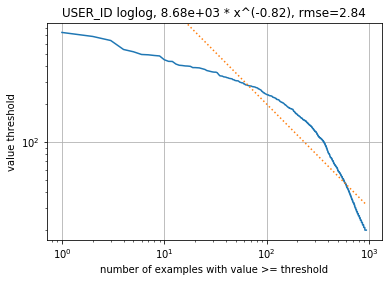


=== ITEM_ID top 10 categories ===
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
dtype: int64


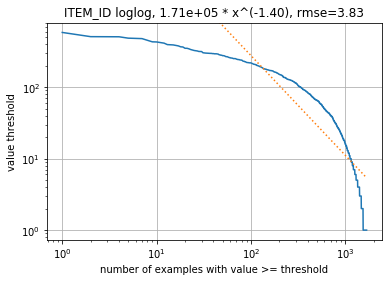


=== Hourly activity pattern ===
0     5172
1     5135
2     4644
3     4853
4     4246
5     4190
6     3500
7     1540
8     1133
9     1951
10    1185
11     637
12     956
13    1662
14    3149
15    3107
16    5426
17    6278
18    6755
19    7112
20    6265
21    8191
22    7231
23    5682
dtype: int64

=== Day of week activity pattern ===
0    13174
1    13933
2    16621
3    13364
4    15918
5    15077
6    11913
dtype: int64


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


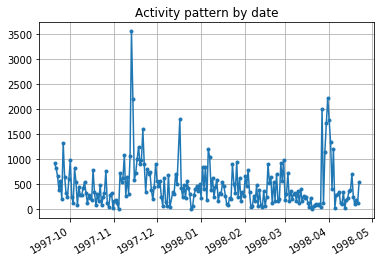

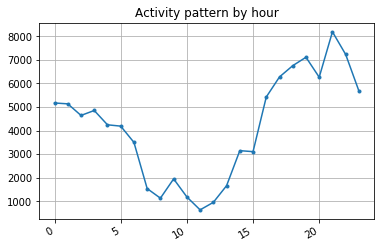

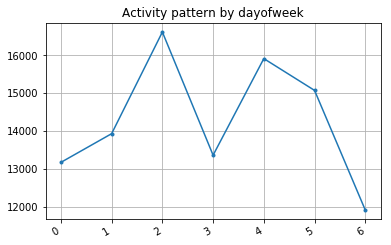


=== Temporal shift analysis ===

Sorting and removing repeated user-items for temporal shift analysis...

=== Temporal shift - retrain frequency ===

temporal total variation, freq=1y, hist_len=0, avg_loss=11.9%, time=0.1s
temporal total variation, freq=1y, hist_len=1, avg_loss=59.6%, time=0.0s
temporal total variation, freq=1q, hist_len=0, avg_loss=15.2%, time=0.1s
temporal total variation, freq=1q, hist_len=1, avg_loss=21.8%, time=0.0s
temporal total variation, freq=1m, hist_len=0, avg_loss=22.2%, time=0.1s
temporal total variation, freq=1m, hist_len=1, avg_loss=21.9%, time=0.0s
temporal total variation, freq=5d, hist_len=0, avg_loss=44.1%, time=0.1s
temporal total variation, freq=5d, hist_len=1, avg_loss=35.9%, time=0.0s
temporal total variation, freq=1d, hist_len=0, avg_loss=70.1%, time=0.1s
temporal total variation, freq=1d, hist_len=1, avg_loss=62.8%, time=0.1s
temporal total variation, freq=6h, hist_len=0, avg_loss=84.6%, time=0.1s
temporal total variation, freq=6h, hist_len=1,

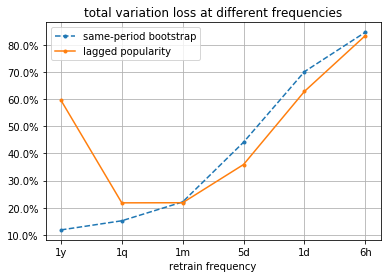

temporal out-sample items, freq=1y, hist_len=0, avg_loss=0.8%, time=0.1s
temporal out-sample items, freq=1y, hist_len=1, avg_loss=54.1%, time=0.0s
temporal out-sample items, freq=1q, hist_len=0, avg_loss=2.0%, time=0.1s
temporal out-sample items, freq=1q, hist_len=1, avg_loss=10.5%, time=0.0s
temporal out-sample items, freq=1m, hist_len=0, avg_loss=4.4%, time=0.1s
temporal out-sample items, freq=1m, hist_len=1, avg_loss=9.3%, time=0.0s
temporal out-sample items, freq=5d, hist_len=0, avg_loss=25.6%, time=0.1s
temporal out-sample items, freq=5d, hist_len=1, avg_loss=18.5%, time=0.0s
temporal out-sample items, freq=1d, hist_len=0, avg_loss=61.6%, time=0.1s
temporal out-sample items, freq=1d, hist_len=1, avg_loss=51.7%, time=0.1s
temporal out-sample items, freq=6h, hist_len=0, avg_loss=81.6%, time=0.1s
temporal out-sample items, freq=6h, hist_len=1, avg_loss=78.2%, time=0.1s


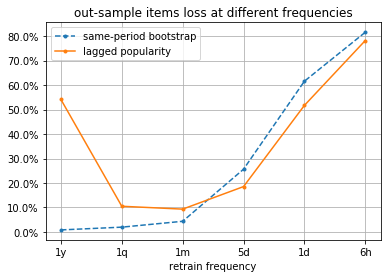


=== Temporal shift - history cutoffs ===

temporal total variation, freq=5d, hist_len=0, avg_loss=44.3%, time=0.1s
temporal total variation, freq=5d, hist_len=1, avg_loss=35.9%, time=0.0s
temporal total variation, freq=5d, hist_len=10, avg_loss=28.5%, time=0.0s
temporal total variation, freq=5d, hist_len=100, avg_loss=28.8%, time=0.1s
temporal total variation, freq=5d, hist_len=1000, avg_loss=28.8%, time=0.1s


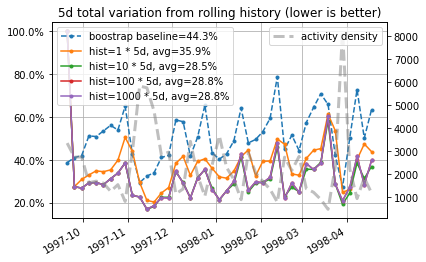

temporal total variation, freq=1d, hist_len=0, avg_loss=70.0%, time=0.1s
temporal total variation, freq=1d, hist_len=1, avg_loss=62.8%, time=0.1s
temporal total variation, freq=1d, hist_len=10, avg_loss=47.8%, time=0.1s
temporal total variation, freq=1d, hist_len=100, avg_loss=46.5%, time=0.1s
temporal total variation, freq=1d, hist_len=1000, avg_loss=46.6%, time=0.1s


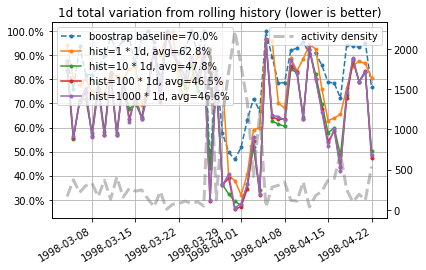

temporal total variation, freq=6h, hist_len=0, avg_loss=85.0%, time=0.1s
temporal total variation, freq=6h, hist_len=1, avg_loss=83.4%, time=0.1s
temporal total variation, freq=6h, hist_len=10, avg_loss=64.5%, time=0.1s
temporal total variation, freq=6h, hist_len=100, avg_loss=62.1%, time=0.2s
temporal total variation, freq=6h, hist_len=1000, avg_loss=62.0%, time=0.3s


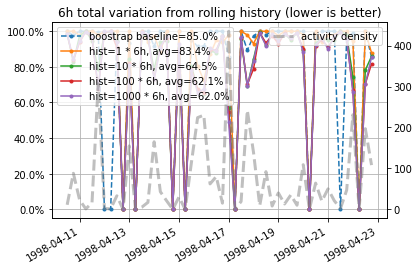

temporal out-sample items, freq=5d, hist_len=0, avg_loss=25.2%, time=0.1s
temporal out-sample items, freq=5d, hist_len=1, avg_loss=18.5%, time=0.0s
temporal out-sample items, freq=5d, hist_len=10, avg_loss=4.8%, time=0.0s
temporal out-sample items, freq=5d, hist_len=100, avg_loss=4.4%, time=0.0s
temporal out-sample items, freq=5d, hist_len=1000, avg_loss=4.4%, time=0.1s


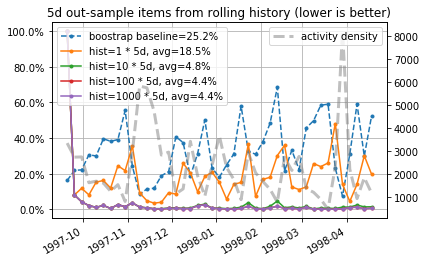

temporal out-sample items, freq=1d, hist_len=0, avg_loss=61.5%, time=0.1s
temporal out-sample items, freq=1d, hist_len=1, avg_loss=51.7%, time=0.1s
temporal out-sample items, freq=1d, hist_len=10, avg_loss=8.5%, time=0.1s
temporal out-sample items, freq=1d, hist_len=100, avg_loss=2.2%, time=0.1s
temporal out-sample items, freq=1d, hist_len=1000, avg_loss=2.2%, time=0.1s


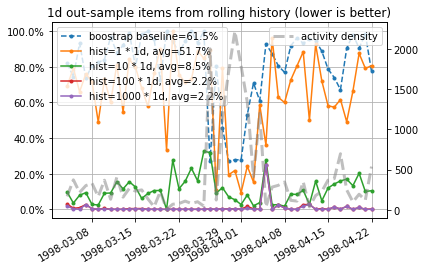

temporal out-sample items, freq=6h, hist_len=0, avg_loss=81.8%, time=0.1s
temporal out-sample items, freq=6h, hist_len=1, avg_loss=78.2%, time=0.1s
temporal out-sample items, freq=6h, hist_len=10, avg_loss=27.8%, time=0.1s
temporal out-sample items, freq=6h, hist_len=100, avg_loss=3.3%, time=0.2s
temporal out-sample items, freq=6h, hist_len=1000, avg_loss=1.8%, time=0.3s


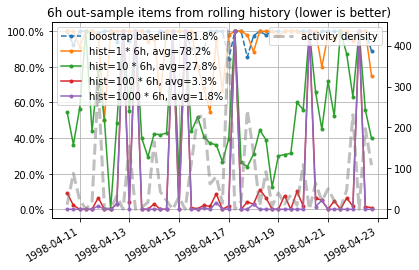


=== session time delta describe ===
count    9.905700e+04
mean     1.921129e+04
std      2.886168e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.700000e+01
max      1.749021e+07
Name: TIMESTAMP, dtype: float64


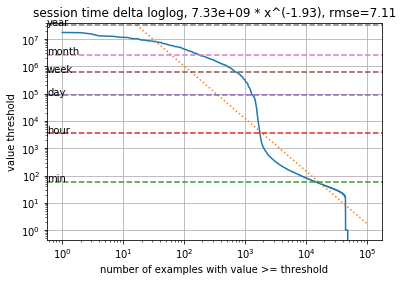

=== user time span describe ===
count    9.430000e+02
mean     2.018041e+06
std      4.389324e+06
min      1.200000e+02
25%      1.057000e+03
50%      2.961000e+03
75%      7.398970e+05
max      1.836258e+07
Name: TIMESTAMP, dtype: float64


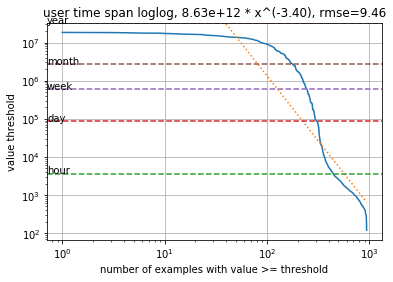

########################################
# DIAGNOSING USERS TABLE, SAMPLE:
########################################
     USER_ID  AGE GENDER     OCCUPATION ZIPCODE
596      597   23      M          other   84116
7          8   36      M  administrator   05201
487      488   48      M     technician   21012
86        87   47      M  administrator   89503
821      822   29      F      librarian   53144
419      420   53      M       educator   02140
941      942   48      F      librarian   78209
294      295   31      M       educator   50325
603      604   39      M       educator   11787
778      779   31      M        student   K7L5J

=== Users table, original shape=(943, 5) ===

Missing rate of all user meta-data 0.0
User coldstart rate 0.0

=== Describe  ===

              AGE
count  943.000000
mean    34.051962
std     12.192740
min      7.000000
25%     25.000000
50%     31.000000
75%     43.000000
max     73.000000

=== GENDER top 10 categories ===
M    670
F    273
dtype: int64

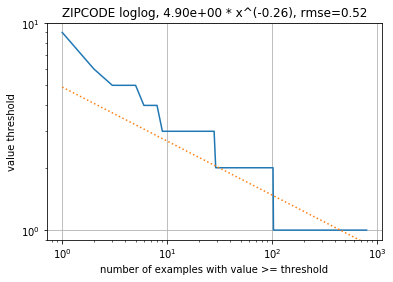

/home/ec2-user/SageMaker/PersonalizePOC/personalizeMetaData/diagnose_personalize_data_utils.py:75: UserWarning: 
            Heavy-tail ZIPCODE distributions are usually hard to learn (slope=-0.26061310393846526)!
            Consider rolling up ZIPCODE or dropping its rare values.
            
  """.format(name, slope))


########################################
# DIAGNOSING ITEMS TABLE, SAMPLE:
########################################
      ITEM_ID                         _TITLE  CREATION_TIMESTAMP   _  \
1261     1262     Walking and Talking (1996)         837129600.0 NaN   
978       979     Trigger Effect, The (1996)         841363200.0 NaN   
1033     1034              Quest, The (1996)         830476800.0 NaN   
1152     1153                Backbeat (1993)         725846400.0 NaN   
82         83  Much Ado About Nothing (1993)         725846400.0 NaN   
199       200            Shining, The (1980)         315532800.0 NaN   
1614     1615      Warriors of Virtue (1997)         862531200.0 NaN   
869       870                   Touch (1997)         855878400.0 NaN   
182       183                   Alien (1979)         283996800.0 NaN   
520       521        Deer Hunter, The (1978)         252460800.0 NaN   

                                              _IMDb_URL  GENRE.0  GENRE.1  \
1261  http://u

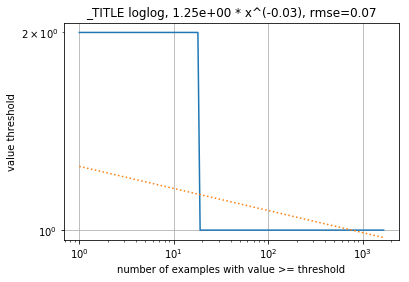

/home/ec2-user/SageMaker/PersonalizePOC/personalizeMetaData/diagnose_personalize_data_utils.py:75: UserWarning: 
            Heavy-tail _TITLE distributions are usually hard to learn (slope=-0.03366036008652356)!
            Consider rolling up _TITLE or dropping its rare values.
            
  """.format(name, slope))



=== _IMDb_URL top 10 categories ===
nan                                                                            3
http://us.imdb.com/M/title-exact?Kull+the+Conqueror+(1997)                     2
http://us.imdb.com/M/title-exact?Hugo+Pool+(1997)                              2
http://us.imdb.com/M/title-exact?Liar+(1997)                                   2
http://us.imdb.com/M/title-exact?Ulee%27s+Gold+(1997)                          2
http://us.imdb.com/M/title-exact?Designated%20Mourner%2C%20The%20%281997%29    2
http://us.imdb.com/M/title-exact?Ice+Storm%2C+The+(1997)                       2
http://us.imdb.com/M/title-exact?Chasing+Amy+(1997)                            2
http://us.imdb.com/Title?Hurricane+Streets+(1998)                              2
http://us.imdb.com/M/title-exact?Nightwatch%20(1997)                           2
dtype: int64


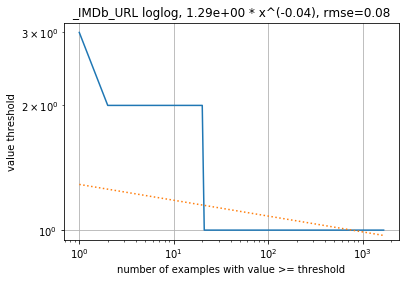

/home/ec2-user/SageMaker/PersonalizePOC/personalizeMetaData/diagnose_personalize_data_utils.py:75: UserWarning: 
            Heavy-tail _IMDb_URL distributions are usually hard to learn (slope=-0.03824519783286997)!
            Consider rolling up _IMDb_URL or dropping its rare values.
            
  """.format(name, slope))


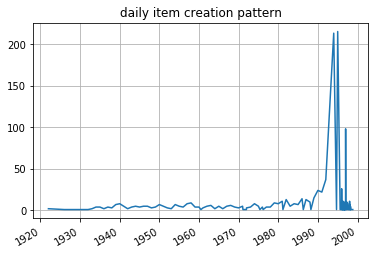

In [84]:
diagnose(interactions, users, items)

## Clean up: Delete Your Campaigns, Solutions and Datasets

The code below deletes the campaigns, solutions and the datasets for this module. 

In [86]:
personalize.delete_campaign(campaignArn=campaign_arn)
while len(personalize.list_campaigns(solutionArn=solution_arn)['campaigns']):
    time.sleep(5)

personalize.delete_solution(solutionArn=solution_arn)
while len(personalize.list_solutions(datasetGroupArn=movielens_dataset_group_arn)['solutions']):
    time.sleep(5)

for dataset in personalize.list_datasets(datasetGroupArn=movielens_dataset_group_arn)['datasets']:
    personalize.delete_dataset(datasetArn=dataset['datasetArn'])
while len(personalize.list_datasets(datasetGroupArn=movielens_dataset_group_arn)['datasets']):
    time.sleep(5)

personalize.delete_dataset_group(datasetGroupArn=movielens_dataset_group_arn)

{'ResponseMetadata': {'RequestId': 'b8bc3018-85da-4bac-a4a5-1a507882ec7a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 17 Feb 2020 12:12:29 GMT',
   'x-amzn-requestid': 'b8bc3018-85da-4bac-a4a5-1a507882ec7a',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

Congratulations. You have gone through an advanced Example using HRNN-Metadata Recipe with MovieLens Data.